# **CE7454 Team Project**
## **Image Inpainting for Old Photos of Singapore**
#### Group 10: Hu Zhi, Sun Chenyu, Zhou Ran


In [3]:
import cv2
import os
import glob
import scipy.misc
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.utils.data as data
import random
import torchvision
import torch
import torch.nn.functional as F
from random import randint
import numpy as np
from PIL import Image
import random
import torch.utils.data as data
import pandas as pd
from task_preprocessing import random_irregular_mask, center_crop

## **1 Motivation and Description**
Image inpainting is a challenging field of exploration. In particular, inpainting refers to the technique of restoring lost parts of an image and reconstructing them based on the background information. Due to many inevitable factors such as poor storage conditions, water stain, low quality of cameras, and human mistakes, various old photos of Singapore are suffering the problem of lost or corrupted parts. These photos and images, however, are valuable assets for the purpose of education, history, and politics. Therefore, it is of great significance if we can reconstruct lost or deteriorated parts of images via some inpainting techniques.

In this project, we aim to explore various inpainting techniques and propose the best solution for reconstructing the missing content in old photos of Singapore. Since the existing solutions always take the publicly available datasets such as CelebA, Places2, and Paris StreetView for model training and testing, we will instead use Singapore related data to obtain more reliable results. A web scraper will be developed to crawl old photos of Singapore from the Google image search engine and other online photo galleries. Then image processing algorithms will be utilized to mask out random area of certain size in each picture. Multiple masked images might be generated from a single source image. A total of around 15,000 source/masked image pairs will be used as training and validation sets. Similarly, a separate test set will be crawled for testing. Subsequently, we will utilize the comparison analysis to evaluate  proposed model with other existing models qualitatively and quantitatively.


## **2 Data Acquisition**

## **3 Data Exploration**
### 3.1 Image Color

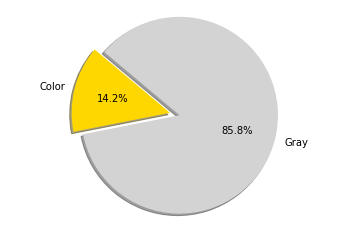

In [6]:
import cv2
import glob
import matplotlib.pyplot as plt
def isgray(img):
    if len(img.shape) < 3: return 1
    if img.shape[2]  == 1: return 1
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return 1
    return 0
#Data Exploration
graycount = 0
filenames = glob.glob('Dataset_Raw/*.*')
for i in range(len(filenames)):
        img = cv2.imread(filenames[i])
        graycount += isgray(img)
colorcount = len(filenames)-graycount

# Data to plot
labels = 'Color', 'Gray'
sizes = [colorcount, graycount]
colors = ['gold', 'lightgray'] 
explode = (0, 0.1)  # explode 2nd slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

<div>
<img src="https://docs.google.com/uc?export=download&id=1tHqFRMy5znJO-V04BsKW2C-EuadEfhLi" width="400"/>
</div>

It can be observed from the plot that the majority of raw images are grayscale. Moreover, given the context of old photos of Singapore, it can be justified that gray images would be the focus in this project. Thus, the color images are converted into grayscale to obtain more consistent and reliable properties of data. Subsequently, the proposed model will only take grayscale images for training and testing.

### 3.2 Image Size

Raw Image Shapes:
Shape (166, 250, 3) counts: 2814
Shape (250, 166, 3) counts: 895
Shape (168, 250, 3) counts: 161
Shape (187, 250, 3) counts: 92
Shape (250, 168, 3) counts: 37
Shape (196, 250, 3) counts: 22
Shape (250, 187, 3) counts: 18
Shape (165, 250, 3) counts: 14
Shape (250, 209, 3) counts: 11
Shape (164, 250, 3) counts: 11
Shape (156, 250, 3) counts: 10
Shape (171, 250, 3) counts: 10
Shape (175, 250, 3) counts: 8
Shape (195, 250, 3) counts: 8
Shape (250, 194, 3) counts: 8
Shape (159, 250, 3) counts: 8
Shape (160, 250, 3) counts: 7
Shape (167, 250, 3) counts: 7
Shape (192, 250, 3) counts: 7
Shape (194, 250, 3) counts: 7
Shape (186, 250, 3) counts: 7
Shape (173, 250, 3) counts: 7
Shape (161, 250, 3) counts: 7
Shape (188, 250, 3) counts: 6
Shape (169, 250, 3) counts: 6
Shape (250, 195, 3) counts: 6
Shape (148, 250, 3) counts: 5
Shape (250, 196, 3) counts: 5
Shape (250, 198, 3) counts: 5
Shape (158, 250, 3) counts: 5
Shape (250, 203, 3) counts: 5
Shape (191, 250, 3) counts: 5
Shape 

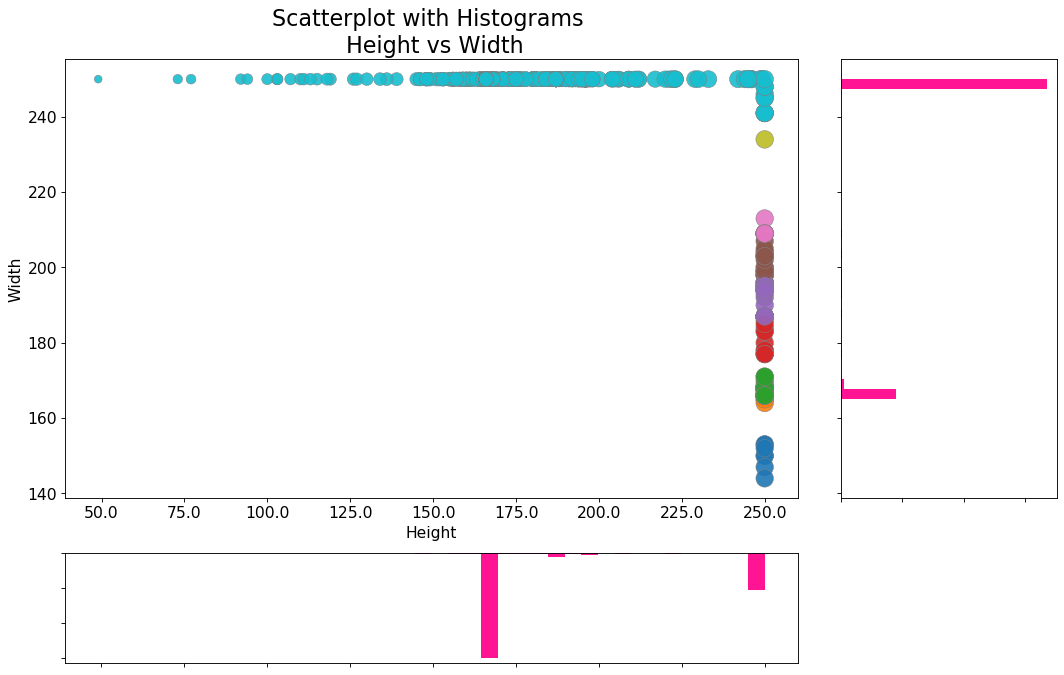

In [7]:
#Size
import pandas as pd
def load_img_shapes(path_to_img):
    return cv2.imread(path_to_img).shape
shapes, heights, widths = [], [], []
filenames = glob.glob('Dataset_Raw/*.*')
for i in range(len(filenames)):
    shape=load_img_shapes(filenames[i])
    shapes.append(shape)
    heights.append(shape[0])
    widths.append(shape[1])

df = pd.DataFrame({'Shapes': shapes, 'Height': heights, 'Width': widths})
counts = df['Shapes'].value_counts()
print("Raw Image Shapes:")
for i in range(len(counts)):
    print("Shape %s counts: %d" % (counts.index[i], counts.values[i]))
print("*"*50)

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('Height', 'Width', s=df.Height, c=df.Width, alpha=.9, data=df, cmap="tab10", edgecolors='gray', linewidths=.5)

# histogram on the right
ax_bottom.hist(df.Height, 40, histtype='stepfilled', orientation='vertical', color='deeppink')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(df.Width, 40, histtype='stepfilled', orientation='horizontal', color='deeppink')

# Decorations
ax_main.set(title='Scatterplot with Histograms \n Height vs Width', xlabel='Height', ylabel='Width')
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
plt.savefig('image_size',dpi=1200)
plt.show()

<div>
<img src="https://docs.google.com/uc?export=download&id=1xPftGO_RrswwnVL28FiQQF3XLwSAzrUJ" width="800"/>
</div>

Based on the generated statistics and scatterplot with histogram of image sizes, the majority size is 166 x 255. However, most of the existing solutions require the training size to be at least 256 x 256. Given the image sizes of our dataset, we decide to use 128 x 128 as default image size for training and testing.

### 3.3 Data Distribution
In this section, we want to explore the distribution of the image data, which is the unique porperty of the dataset. It should be noted that the target image data in this section is the data after pre-processing in **Section 4**. 

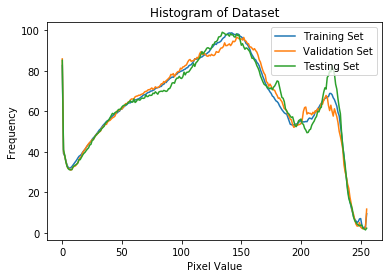

In [8]:
# Analyze the data after preprocessing
train_filenames = glob.glob('Dataset/Training/Origin/*.*')
valid_filenames = glob.glob('Dataset/Validation/Origin/*.*')
test_filenames = glob.glob('Dataset/Testing/Origin/*.*')

train_histr=0
valid_histr=0
test_histr=0
# reads a training image 
for i in range(len(train_filenames)):
        img = cv2.imread(train_filenames[i], 0)       
        train_histr += cv2.calcHist([img],[0],None,[256],[0,256]) # find frequency of pixels in range 0-255 
train_histr = train_histr / len(train_filenames) 
        
# reads a validation image 
for i in range(len(valid_filenames)):
        img = cv2.imread(valid_filenames[i], 0)
        valid_histr += cv2.calcHist([img],[0],None,[256],[0,256]) 
valid_histr = valid_histr / len(valid_filenames) 

# reads a testing image 
for i in range(len(test_filenames)):
        img = cv2.imread(test_filenames[i], 0)
        test_histr += cv2.calcHist([img],[0],None,[256],[0,256]) 
test_histr = test_histr / len(test_filenames) 

# show the plotting graph of an image 
plt.plot(train_histr) 
plt.plot(valid_histr)
plt.plot(test_histr)
plt.ylabel('Frequency')
plt.xlabel('Pixel Value')
plt.title('Histogram of Dataset')
plt.legend(('Training Set', 'Validation Set', 'Testing Set'),
           loc='upper right')
plt.savefig('Histogram',dpi=1200)
plt.show() 



<img src="https://docs.google.com/uc?export=download&id=1GDRbv9Bo24fqTAiSRhMWQA3eSgo5FQ2y" width="500"/>
</div>

Based on the above histogram plot, it can be concluded that the overall distributions of training set, validation set and testing set after preprocessing are consistent. Meanwhile, we could identify some perporties of old photos of Singapore. The maximum is attained at around pixel value = 150. The overall image are a bit light since the histogram values are concentrated toward the right. The majority pixel values are from 50 to 200. However, there is a modal at around pixel value = 230, which is quite obvious in the testing data. The black pixels (pixel value = 0) are much more than the white pixels (pixel value = 255). In addition, the overall image data indicates good contrast because the pixel counts evenly cover a broad range of grayscale levels.

Therefore, we would like to incorporiate the dataset distribution into the loss function in our proposed model, which will be demonstrated in details in **Section 5**.

## **4 Pre-processing**

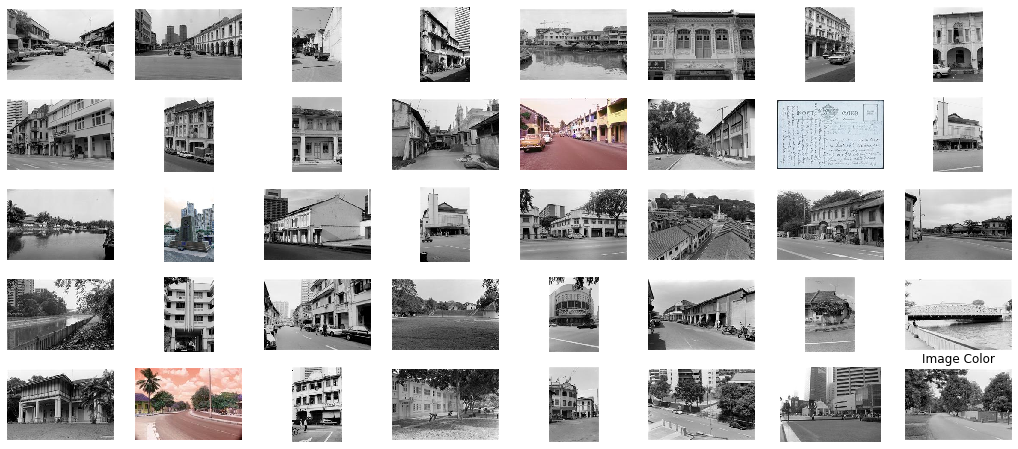

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
filenames = glob.glob('Dataset_Raw/*.*')
hides, shows = train_test_split(filenames, test_size=0.07, random_state=100 )
w=10
h=10
fig=plt.figure(figsize=(18, 8))
columns = 8
rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(shows[i])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.title('Image Color')
plt.savefig('random_raw',dpi=1200)
plt.show()


<img src="https://docs.google.com/uc?export=download&id=1VoNJU6rBlLbboMdEkdN0oNSWIm8YbAwT" width="1000"/>
</div>

By looking at some random samples from the raw dataset, outliers are identified, which includes low-quality images, drawings, postcards, recent photos, etc. Therefore, we carried out data cleaning to exclude those outlier images.

In [ ]:
filenames = glob.glob('data1/*.*') #Dataset after cleaning
for i in range(len(filenames)):
        img = cv2.imread(filenames[i], 1)
        a,b,c = img.shape
        if a >= 128 and b >= 128 and c==3:
            #image crop
            image = center_crop(img, 128, 128)
            image = Image.fromarray(image)
            # convert to RGB
            image = image.convert('RGB')  
            image = np.asarray(image)
            cv2.imwrite('data2/'+ str(i).zfill(4) + '.'  + filenames[i].split('/')[1].split('.')[1], image)

After cleaning the data, the first preprocessing tasks were carried out in the above block as follows:


*   Remove images with height or width less than 128 as discussed in **Section 3**
*   Resize the remaining images to 128 x 128 via center crop
*   Convert the color data into grayscale as discussed in **Section 3**








In [ ]:
#Preprocessing2
from sklearn.model_selection import train_test_split
filenames = glob.glob('data2/*.*')
training_valid, testset = train_test_split(filenames, test_size=0.1, random_state=42 )
trainingset, validationset = train_test_split(training_valid, test_size=0.125, random_state=42 )
#Trainingset
for k in range(4)
    for i in range(len(trainingset)):
        img = cv2.imread(trainingset[i], 1)
        image = Image.fromarray(img)
        image = image.convert('RGB')  
        mask = random_irregular_mask(image)
        img = transforms.ToTensor()(image)
        img = img * mask + (1-mask)
        img = torchvision.transforms.ToPILImage()(img)
        img = np.asarray(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     
        cv2.imwrite('Dataset/Training/Apply_mask/'+ str(i+k*len(trainingset)).zfill(5)+ '.jpg', img)
        cv2.imwrite('Dataset_grayscale/Training/Apply_mask/'+ str(i+k*len(trainingset)).zfill(5)+ '.jpg', gray)
        mask = torchvision.transforms.ToPILImage()(1-mask)
        mask = np.asarray(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)    
        cv2.imwrite('Dataset/Training/Mask/'+ str(i+k*len(trainingset)).zfill(5)+ '.jpg', mask)
        cv2.imwrite('Dataset_grayscale/Training/Mask/'+ str(i+k*len(trainingset)).zfill(5)+ '.jpg', gray_mask)
        image = np.asarray(image)
        gray_org = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('Dataset/Training/Origin/' + str(i+k*len(trainingset)).zfill(5)+ '.jpg', image)
        cv2.imwrite('Dataset_grayscale/Training/Origin/' + str(i+k*len(trainingset)).zfill(5)+ '.jpg', gray_org)
#Validationset
for i in range(len(validationset)):
        img = cv2.imread(validationset[i], 1)
        image = Image.fromarray(img)
        image = image.convert('RGB')  
        mask = random_irregular_mask(image)
        img = transforms.ToTensor()(image)
        img = img * mask + (1-mask)
        img = torchvision.transforms.ToPILImage()(img)
        img = np.asarray(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        cv2.imwrite('Dataset/Validation/Apply_mask/'+ validationset[i].split('/')[1], img)
        cv2.imwrite('Dataset_grayscale/Validation/Apply_mask/'+ validationset[i].split('/')[1], gray)
        mask = torchvision.transforms.ToPILImage()(1-mask)
        mask = np.asarray(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  
        cv2.imwrite('Dataset/Validation/Mask/'+ validationset[i].split('/')[1], mask)
        cv2.imwrite('Dataset_grayscale/Validation/Mask/'+ validationset[i].split('/')[1], gray_mask)
        image = np.asarray(image)
        gray_org = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('Dataset/Validation/Origin/' + validationset[i].split('/')[1], image)
        cv2.imwrite('Dataset_grayscale/Validation/Origin/' + validationset[i].split('/')[1], gray_org)
#Testset
for i in range(len(testset)):
        img = cv2.imread(testset[i], 1)
        image = Image.fromarray(img)
        image = image.convert('RGB')  
        mask = random_irregular_mask(image)
        img = transforms.ToTensor()(image)
        img = img * mask + (1-mask)
        img = torchvision.transforms.ToPILImage()(img)
        img = np.asarray(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        cv2.imwrite('Dataset/Testing/Apply_mask/'+ testset[i].split('/')[1], img)
        cv2.imwrite('Dataset_grayscale/Testing/Apply_mask/'+ testset[i].split('/')[1], gray)
        mask = torchvision.transforms.ToPILImage()(1-mask)
        mask = np.asarray(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  
        cv2.imwrite('Dataset/Testing/Mask/'+ testset[i].split('/')[1], mask)
        cv2.imwrite('Dataset_grayscale/Testing/Mask/'+ testset[i].split('/')[1], gray_mask)
        image = np.asarray(image)
        gray_org = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.imwrite('Dataset/Testing/Origin/' + testset[i].split('/')[1], image)
        cv2.imwrite('Dataset_grayscale/Testing/Origin/' + testset[i].split('/')[1], gray_org)

Subsequently, the following preprocessing tasks are carried out:


*   Shuffle and split the entire dataset into training, validation and testing sets with the slit ratio of 8 : 1 : 1.
*   Apply random mask with mask areas of 10% to 40% to the original image and save the original images, masks and masked images respectively.
*   5 differernt masks are applied to each original images in the training set, which is to increase the data size and avoid overfitting



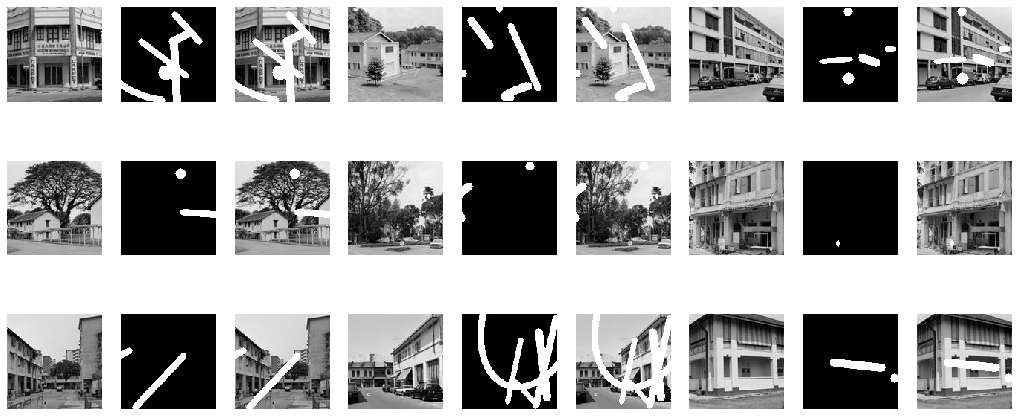

In [10]:
#Display random images
origin = glob.glob('Dataset/Validation/Origin/*.*')
mask = glob.glob('Dataset/Validation/Mask/*.*')
masked = glob.glob('Dataset/Validation/Apply_mask/*.*')
fig=plt.figure(figsize=(18, 8))
columns = 9
rows = 3
for i in range(1, 10):
    img = cv2.imread(origin[i])
    fig.add_subplot(rows, columns, i*3-2)
    plt.axis('off')
    plt.imshow(img)
    img = cv2.imread(mask[i])
    fig.add_subplot(rows, columns, i*3-1)
    plt.axis('off')
    plt.imshow(img)    
    img = cv2.imread(masked[i])
    fig.add_subplot(rows, columns, i*3)
    plt.axis('off')
    plt.imshow(img)
plt.savefig('masked_sample',dpi=1200)
plt.show()

<img src="https://docs.google.com/uc?export=download&id=1KBeN-_jQUVdrv5SmQJEnA2_aB4zD2HWx" width="1200"/>
</div>

The above plot shows some image data of original image, mask and masked images. It should be noted that the random irregular masks are applied in order to simulate the damage to old photos due to various factors. 

## **5 Existing Solutions and Proposed Solutions**



Existing Solutions:
1. Context Encoder (Baselline Model):
   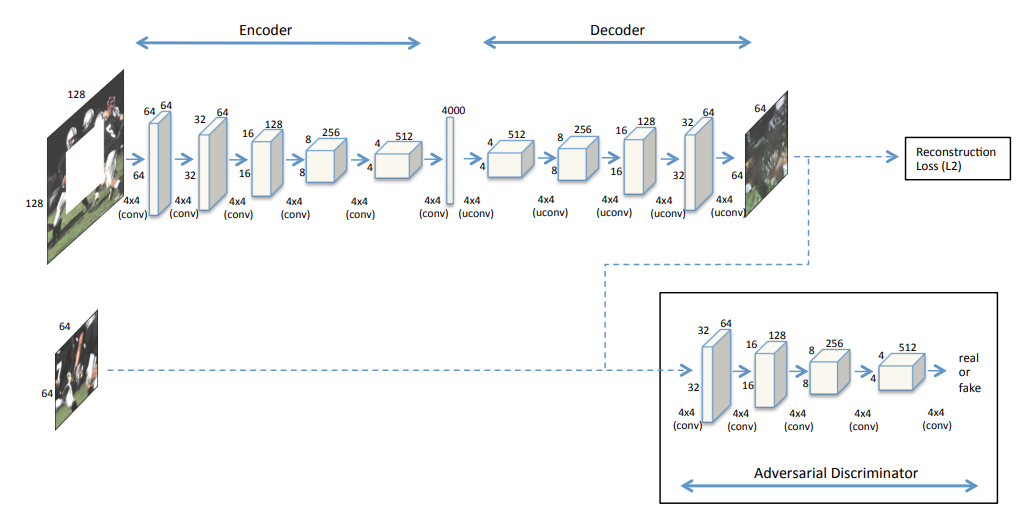

As shown in the figure above, context encoder(CE) adopts a encoder-decoder structure where the encoder maps an image with missing regions to a low-dimensional feature space, then this low-dimensional feature information are passed to decoder through a channel-wise(RGB) fully connected layer. Decoder then performs up-convolution to construct the image. The network loss is defined as the weighted sum of reconstruction loss(L2) and adversarial loss, a discriminator will assess the local consistency of the generated patches. DCGAN loss is used as adversarial loss in this model.
However, the recovered regions of the output image often contain visual artifacts and exhibit blurriness due to the information bottleneck in the channel-wise fully connected layer.

2.  Globally and Locally Consistent Image Completion(GLCIC):
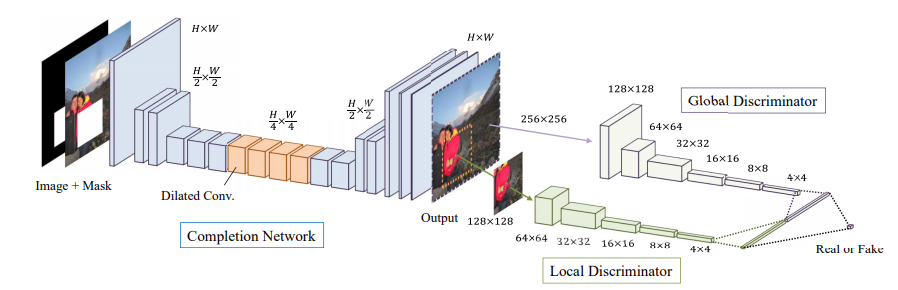

As shown in the figure above, as compared to Context Encoder, this model contains two major changes. Firstly, the channel-wise fully conntected layers are replaced by a series of dilated CNN layers, this is to allow the model to compute each output pixel with a much larger input area as the dilated kernels are more sparse. Secondly, instead of using only one local discriminator, a global discriminator is added to scan the entire image to evaluate whethere it is coherent as a whole. DCGAN loss is used as adversarial loss in this model.

3. Generative Image Inpainting with Contextual Attention(GIICA):
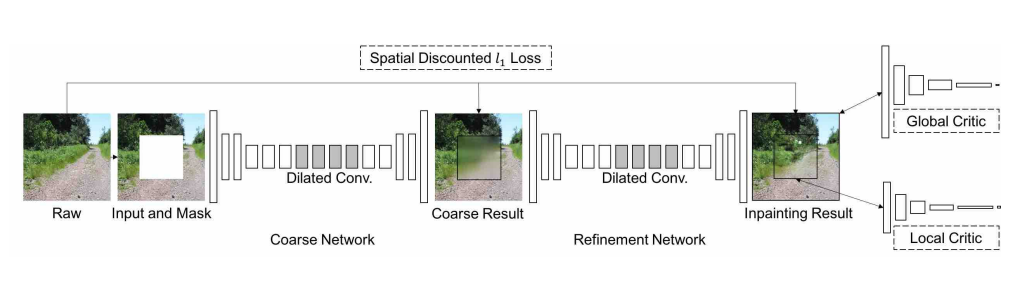

As shown in the figure above, differ from the aforementioned models, Contextual Attention takes a two-step approach to the problem of image inpainting. First, it produces a coarse estimate of the missing region using GLCIC structure based on L1 loss. Next, a refinement network sharpens the result using an attention mechanism by searching for a collection of background patches with the highest similarity to the coarse estimate. The advantage of using attention mechnism is to reduce the exhibit blurriness and make the inpainted image looks like a coherent picture. 
At the second phase, same as GLCIC model, this model also uses two discriminators(local and global) for the computation of GAN loss. WGAN-GP(Wasserstein GAN with Gradient Penalty) loss is used as adversarial loss in this model to improve the model stability and convergence speed.

4. EDGE-aware Context Encoder for Image Inpainting(EDGE-CE)
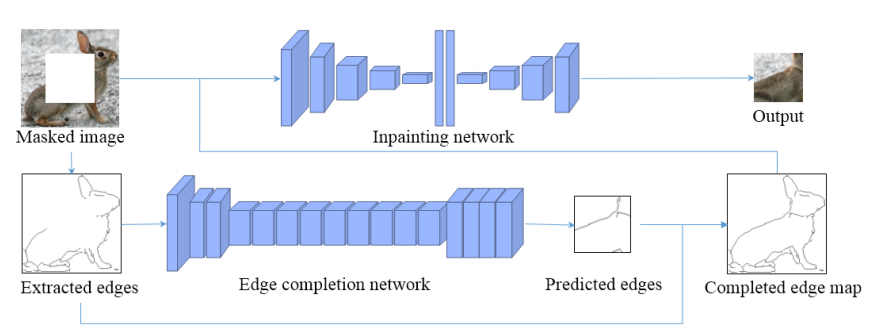

As shown in the figure above, EDGE-CE model also takes a two-step approach to perform the task of image inpainting. However, this model follows painter's practice: "Skeleton first, Colors second". Firstly, EDGE-CE adopts a edge completion network to output a predicted edge map. At the second phase, the inpainting network uses the predicted edge map and masked image to output a completed color image. The edge map in this phase provides a clear guidance for the inpainting work,and reduce the blurriness on the boundary.

Proposed Solution:
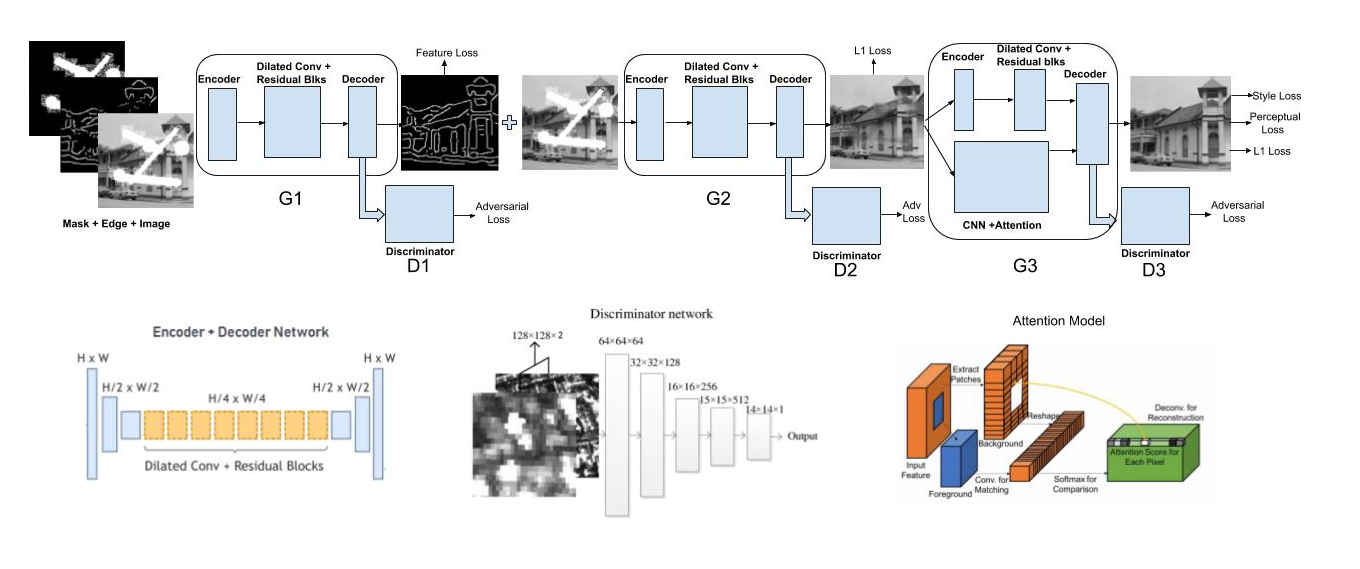

公式

By combining the advantages of the above-mentioned models and inspired by the EDGE-CE model and recent research paper: edgeconnect, we propose the model in figure ???. Our proposed model uses a three-step approach to perform iamge inpainting.
Firstly, we uses the encoder-decoder network to generate a predicted edge map using feature loss(generator l1 loss) combined with adversarial loss. Secondly, we input the predicted edge map together with the masked image to a coarse image generator, at this step, the aim is to output a coarse inpainted image. However, the coarse result shoule be reasonably good as the coarse estimate will be compared with background patches in next phase to form a coherent image. Thus, we uses a combined loss of L1 loss and adversarial loss in this phase for back-propagation training. Lastly, we adopts the attention mechanism to compute the matching score of foreground pathces(masked region) with background patches(CNN filters). Then we apply softmax function to compare and compute attention score for each pixel and finally, we reconstruct foreground patches with background patches by performing deconvolution on attention socre. In this stage, we uses 4 losses, L1 loss is to recover low frequency information; Style loss and perceptual loss are to make the generated image looks perceptually correct as the original picture; Adversarial loss is to make the generated image looks coherent as a whloe. Spectral Normalization is utilized in the model to meet the 1-Lipschitz constraint.


In [18]:
run EIWA.py --mode 2

GPU in use...
5
3
Loading EdgeModel generator...
Loading InpaintingModel generator...
Loading InpaintingFineModel generator...
Model configurations:
---------------------------------
MODE: 1             # 1: train, 2: test, 3: eval
MODEL: 5            # 1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: fine-inpaint model, 5: joint model
MASK: 3             # 1: random block, 2: half, 3: external, 4: (external, random block), 5: (external, random block, half)
EDGE: 1             # 1: canny, 2: external
NMS: 1              # 0: no non-max-suppression, 1: applies non-max-suppression on the external edges by multiplying by Canny
SEED: 10            # random seed
GPU: [0]            # list of gpu ids
DEBUG: 0            # turns on debugging mode
VERBOSE: 0          # turns on verbose mode in the output console

TRAIN_FLIST: ./data/flist/ori_train.flist
VAL_FLIST: ./data/flist/ori_vali.flist
TEST_FLIST: ./data/flist/ori_test.flist

TRAIN_EDGE_FLIST: ./data/flist/edge_train.flist
VAL

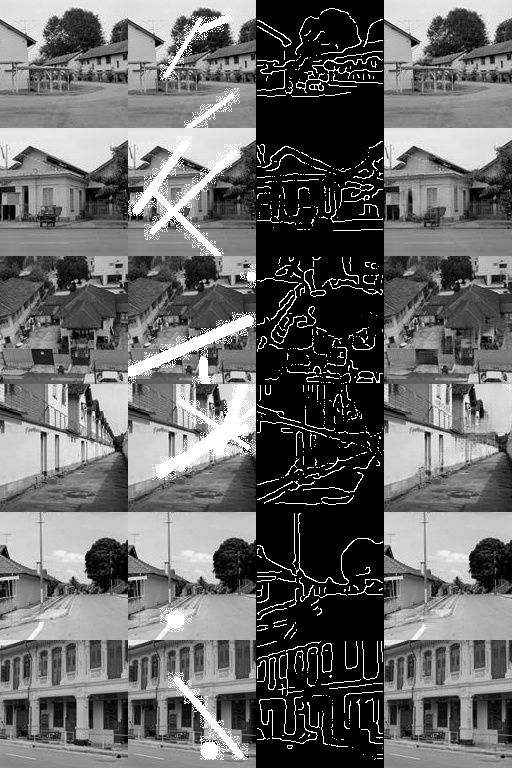

In [33]:
from IPython.display import Image
PATH = "/home/sunchenyu1993/work_ws/edge_inpainting_with_attention/checkpoints/results/vis/"
Image(filename = PATH + "test_vis.png", width=500, height=200)

## **6 Results Analysis**

In [38]:
%tb

SystemExit: 2

In [44]:

run test_generative_inpainting.py --image generative_inpainting/Dataset/Testing/Origin --checkpoint_dir generative_inpainting/logs/full_model12 --mask generative_inpainting/Dataset/Testing/Mask --output generative_inpainting/Dataset/Testing/Results

---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: nvidia-tesla-p4
name: deep
model_restore: logs/full_model11
dataset: mydata
random_crop: True
val: False
log_dir: logs/full_model12
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 800
max_iters: 10000
viz_max_out: 5
val_psteps: 200
data_flist: 
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/train_shuffled.flist', 'data/celeba/validation_static_view.flist']
  places2: ['data/places2/train_shuffled.flist', 'data/places2/validation_static_view.flist']
  imagenet: ['data/imagenet/train_shuffled.flist', 'data/imagenet/validation_static_view.flist']
  mydata: ['data_flist/train_shuffled.flist', 'data_flist/validation_static_view.flist']
static_view_size: 2
img_shapes: [128, 128, 3]
h

ValueError: Variable inpaint_net/conv1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/sunchenyu1993/CE7454/generative_inpainting/inpaint_ops.py", line 45, in gen_conv
    activation=None, padding=padding, name=name)
  File "/home/sunchenyu1993/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 183, in func_with_args
    return func(*args, **current_args)
  File "/home/sunchenyu1993/CE7454/generative_inpainting/inpaint_model.py", line 48, in build_inpaint_net
    x = gen_conv(x, cnum, 5, 1, name='conv1')


SyntaxError: invalid syntax (<ipython-input-32-910bd6ef6eb3>, line 1)

## **7 Conclusion**

## **References**